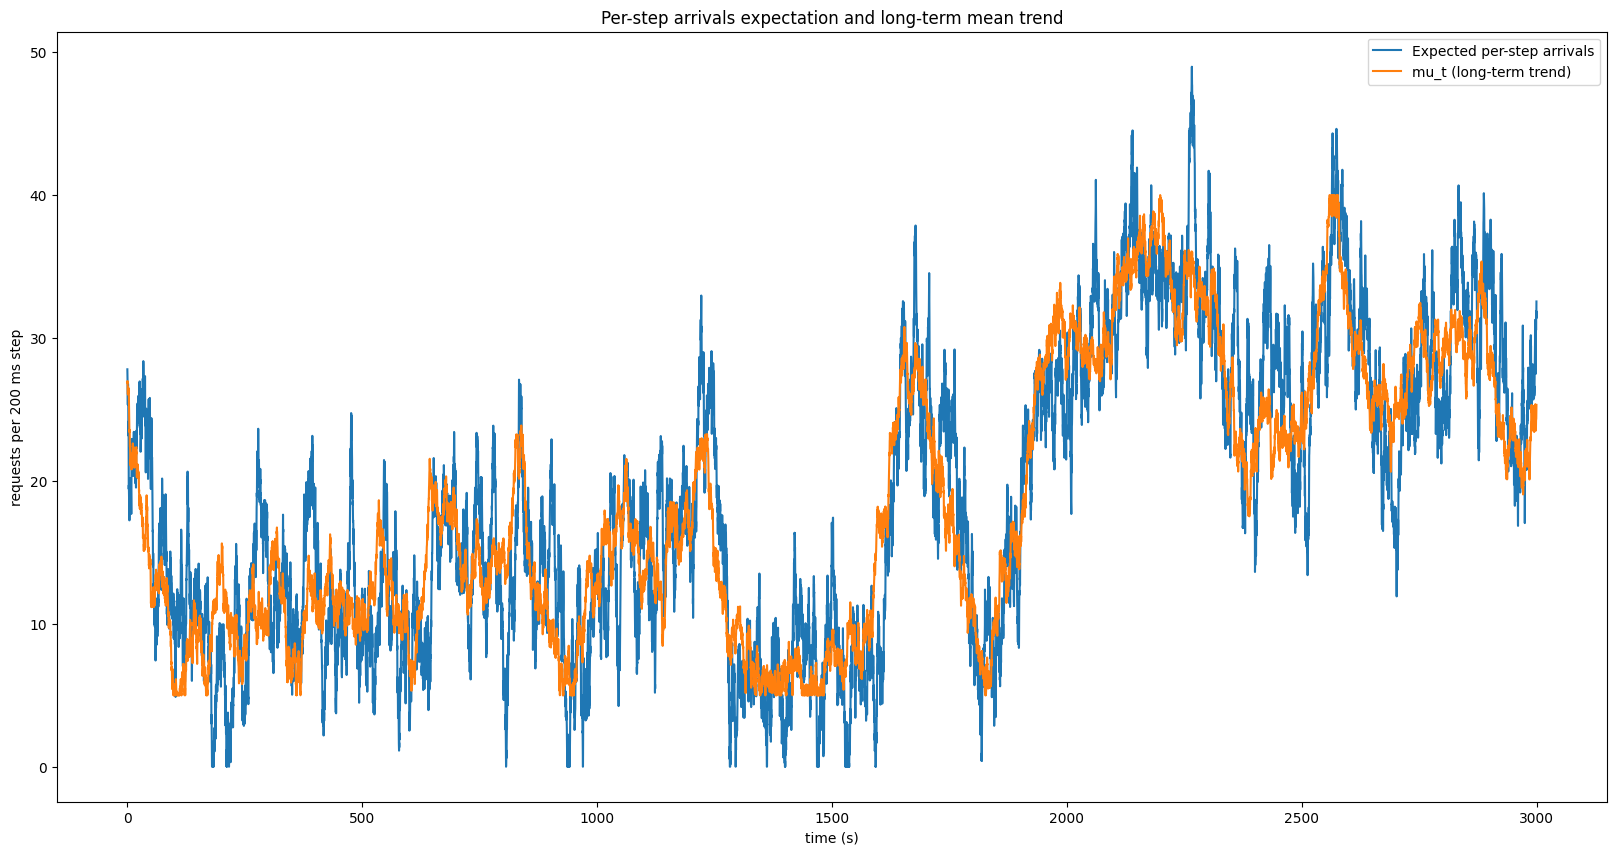

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def generate_req_trace(
    t_steps: int,
    slot_ms: float,
    rng: np.random.Generator,
    rw_sigma_per_sqrt_sec: float = 0.8,
    mu_min: float = 5.0,
    mu_max: float = 40.0,
    kappa: float = 0.02,
    sigma: float = 0.9,
):
    dt = slot_ms / 1000.0

    mu0 = float(rng.uniform(mu_min, mu_max))

    mu_series = np.empty(t_steps, dtype=float)
    mu_series[0] = mu0
    for t in range(1, t_steps):
        step = rw_sigma_per_sqrt_sec * np.sqrt(dt) * rng.standard_normal()
        mu_series[t] = np.clip(mu_series[t - 1] + step, mu_min, mu_max)

    x = float(mu_series[0])
    req_per_sec = np.zeros(t_steps, dtype=float)

    for t in range(t_steps):
        mu_t = float(mu_series[t])
        x = x + kappa * (mu_t - x) + sigma * rng.standard_normal()
        x = max(0.0, x)
        req_per_sec[t] = x

    req_per_step_expected = req_per_sec
    req_per_step = np.maximum(req_per_step_expected, 0.0)

    return pd.DataFrame(
        {
            "t": np.arange(t_steps, dtype=int),
            "mu0": mu0,
            "mu_t": mu_series,
            "req_per_sec": req_per_sec,
            "req_per_step_expected": req_per_step_expected,
            "num_requests_per_step": req_per_step,
        }
    )


# ------------ demo plot ------------
slot_ms = 200.0
t_max = 15000

cfg = {
    "rw_sigma_per_sqrt_sec": 0.8,
    "mu_min": 5.0,
    "mu_max": 40.0,
    "kappa": 0.02,
    "sigma": 0.9,
}

rng = np.random.default_rng(7)

time_s = np.arange(t_max) * (slot_ms / 1000.0)

df = generate_req_trace(
    t_steps=t_max,
    slot_ms=slot_ms,
    rng=rng,
    rw_sigma_per_sqrt_sec=cfg["rw_sigma_per_sqrt_sec"],
    mu_min=cfg["mu_min"],
    mu_max=cfg["mu_max"],
    kappa=cfg["kappa"],
    sigma=cfg["sigma"],
)

plt.figure(figsize=(20, 10))
plt.plot(time_s, df["req_per_step_expected"], label="Expected per-step arrivals")
plt.plot(time_s, df["mu_t"], label="mu_t (long-term trend)")
plt.xlabel("time (s)")
plt.ylabel(f"requests per {slot_ms:.0f} ms step")
plt.title("Per-step arrivals expectation and long-term mean trend")
plt.legend()
plt.show()

# Allocate Detectors

In [ ]:
def allocate_detectors(
    det_costs: dict,            # {det: cycles_per_req}
    det_quality: dict | None,   # {det: score}, optional
    N: int,
    mu_cycles_per_ms: float,    # avail_cycles_aft_atk_per_ms (cycles per ms)
    D_max:int,
    gamma: float = 0.0,         # latency penalty strength (0 = hard cutoff)
):
    """
    Feasible detector mixing where feasibility is defined by a latency constraint
    computed from the current available CPU cycles.

    Latency model (per slot):
    total_cycles = sum_det n_det * c_det
    mean_latency_ms = total_cycles / mu_cycles_per_ms

    Constraint:
    mean_latency_ms <= D_Max
    Equivalent cycle budget:
    total_cycles <= D_Max * mu_cycles_per_ms

    Returns:
    plan: {det: n_req}
    feasible_all: bool
    dropped: int
    used_cycles: float
    mean_latency_ms: float
    qoe: float  (average QoE over original N, dropped contribute 0)
    """
    import math


    # no requests means no violation and full satisfaction
    if N == 0:
        return {}, True, 0, 0.0, 0.0, 1.0

    # invalid compute or latency bound means cannot serve any positive demand
    if N < 0:
        N = 0
    if mu_cycles_per_ms <= 1e-12 or D_max <= 0:
        return {}, False, int(N), 0.0, float("inf"), 0.0

    # cycle budget implied by current compute and latency bound
    C_budget = float(D_max) * float(mu_cycles_per_ms)

    # sort detectors by quality (desc), if missing then by cost (desc)
    dets = list(det_costs.keys())
    if not dets:
        return {}, False, int(N), 0.0, float("inf"), 0.0

    dets.sort(key=lambda d: float(det_quality[d]), reverse=True)
    qmax = max(1e-12, max(float(det_quality[d]) for d in dets))
    qnorm = {d: float(det_quality[d]) / qmax for d in dets}  # 0..1

    # cheapest detector as backstop
    det_light = min(dets, key=lambda d: float(det_costs[d]))
    cL = float(det_costs[det_light])

    # helper QoE from plan
    def _qoe_from_plan(plan: dict, dropped: int, used_cycles: float):
        served = int(sum(plan.values()))
        mean_latency = used_cycles / max(1e-9, mu_cycles_per_ms) if served > 0 else float("inf")

        if mean_latency >= D_max:
            lat_pen = 1.0
        else:
            lat_pen = math.exp(-gamma * (mean_latency - D_max)) if gamma > 0 else 0.0
        lat_pen = 1.0
        quality_sum = 0.0
        for det, n in plan.items():
            quality_sum += float(n) * float(qnorm.get(det, 0.0))

        qoe = (quality_sum / float(N)) * float(lat_pen) if N > 0 else 0.0
        return float(qoe), float(mean_latency)

    # if even all-light violates latency bound, serve what we can with lightest
    if N * cL > C_budget + 1e-9:
        served = int(C_budget // cL) if cL > 0 else 0
        served = max(0, min(N, served))
        plan = {det_light: served} if served > 0 else {}
        used = served * cL
        dropped = N - served
        qoe, mean_lat = _qoe_from_plan(plan, dropped, used)
        return plan, False, int(dropped), float(used), float(mean_lat), float(qoe)

    # otherwise, all N can meet latency bound, now maximize quality with feasibility backstop
    plan = {d: 0 for d in dets}
    B = float(C_budget)
    R = int(N)

    for det in dets:
        if det == det_light:
            continue
        if R <= 0:
            break

        ck = float(det_costs[det])
        if ck <= cL + 1e-12:
            continue

        # keep enough budget to run remaining requests using the lightest detector
        # n <= (B - R*cL) / (ck - cL)
        numer = B - R * cL
        denom = ck - cL
        n_max = math.floor(numer / denom + 1e-12) if denom > 0 else 0
        n = max(0, min(R, int(n_max)))

        if n > 0:
            plan[det] += n
            B -= n * ck
            R -= n

    if R > 0:
        plan[det_light] += R
        B -= R * cL
        R = 0

    used_cycles = C_budget - B
    assert sum(plan.values()) == N
    assert used_cycles <= C_budget + 1e-6

    qoe, mean_lat = _qoe_from_plan(plan, 0, used_cycles)
    return plan, True, 0, float(used_cycles), float(mean_lat), float(qoe)

def allocate_detectors_opt_dp(
    det_costs: dict,            # {det: cycles_per_req}
    det_quality: dict | None,   # {det: score}
    N: int,
    mu_cycles_per_ms: float,    # cycles per ms
    D_max: float,               # ms latency bound
    gamma: float = 0.0,
):
    """
    Optimal integer allocation via MILP (exact), falls back to greedy if PuLP not available.

    Constraints:
      sum_det n_det <= N
      sum_det n_det * c_det <= C_budget = D_max * mu_cycles_per_ms
      n_det are integers >= 0

    Objective:
      maximize (served * BIG + quality_sum_norm) so it serves as many as possible first,
      then maximizes quality among those.
    """
    import math

    if N <= 0:
        return {}, True, 0, 0.0, 0.0, 1.0
    if mu_cycles_per_ms <= 1e-12 or D_max <= 0 or not det_costs:
        return {}, False, int(N), 0.0, float("inf"), 0.0
    if det_quality is None:
        det_quality = {d: 1.0 for d in det_costs.keys()}

    dets = list(det_costs.keys())
    C_budget = float(D_max) * float(mu_cycles_per_ms)

    # normalize quality 0..1
    qmax = max(1e-12, max(float(det_quality[d]) for d in dets))
    qnorm = {d: float(det_quality[d]) / qmax for d in dets}
    c = {d: float(det_costs[d]) for d in dets}

    def _qoe_from_plan(plan: dict, used_cycles: float):
        served = int(sum(plan.values()))
        mean_latency = used_cycles / max(1e-9, mu_cycles_per_ms) if served > 0 else float("inf")
        if mean_latency <= D_max:
            lat_pen = 1.0
        else:
            lat_pen = math.exp(-gamma * (mean_latency - D_max)) if gamma > 0 else 0.0
        quality_sum = sum(float(n) * float(qnorm.get(d, 0.0)) for d, n in plan.items())
        qoe = (quality_sum / float(N)) * float(lat_pen)
        return float(qoe), float(mean_latency)

    # ---------- exact MILP (PuLP) ----------
    try:
        import pulp

        prob = pulp.LpProblem("allocate_detectors", pulp.LpMaximize)
        n_vars = {d: pulp.LpVariable(f"n_{d}", lowBound=0, upBound=N, cat=pulp.LpInteger) for d in dets}

        served = pulp.lpSum([n_vars[d] for d in dets])
        used = pulp.lpSum([c[d] * n_vars[d] for d in dets])

        prob += served <= int(N)
        prob += used <= float(C_budget)

        # serve-max then quality-max
        BIG = 10.0  # BIG should dominate quality_sum_norm/N (<=1)
        quality_sum = pulp.lpSum([qnorm[d] * n_vars[d] for d in dets])
        prob += BIG * served + quality_sum

        # solve
        prob.solve(pulp.PULP_CBC_CMD(msg=False))

        plan = {}
        for d in dets:
            v = int(round(pulp.value(n_vars[d]) or 0))
            if v > 0:
                plan[d] = v

        served_int = int(sum(plan.values()))
        used_cycles = float(sum(c[d] * n for d, n in plan.items()))
        dropped = int(N - served_int)
        feasible_all = (dropped == 0)

        qoe, mean_lat = _qoe_from_plan(plan, used_cycles)
        return plan, feasible_all, dropped, float(used_cycles), float(mean_lat), float(qoe)

    except Exception:
        pass

    # ---------- fallback: your original feasible greedy ----------
    # (kept minimal so you can drop in your own)
    dets.sort(key=lambda d: float(det_quality[d]), reverse=True)
    det_light = min(dets, key=lambda d: float(det_costs[d]))
    cL = float(det_costs[det_light])

    if N * cL > C_budget + 1e-9:
        served = int(C_budget // cL) if cL > 0 else 0
        served = max(0, min(N, served))
        plan = {det_light: served} if served > 0 else {}
        used_cycles = served * cL
        dropped = N - served
        qoe, mean_lat = _qoe_from_plan(plan, used_cycles)
        return plan, False, int(dropped), float(used_cycles), float(mean_lat), float(qoe)

    plan = {d: 0 for d in dets}
    B = float(C_budget)
    R = int(N)

    for det in dets:
        if det == det_light or R <= 0:
            continue
        ck = float(det_costs[det])
        if ck <= cL + 1e-12:
            continue
        numer = B - R * cL
        denom = ck - cL
        n_max = math.floor(numer / denom + 1e-12) if denom > 0 else 0
        n = max(0, min(R, int(n_max)))
        if n > 0:
            plan[det] += n
            B -= n * ck
            R -= n

    if R > 0:
        plan[det_light] += R
        B -= R * cL

    used_cycles = C_budget - B
    qoe, mean_lat = _qoe_from_plan({d: n for d, n in plan.items() if n > 0}, used_cycles)
    return {d: n for d, n in plan.items() if n > 0}, True, 0, float(used_cycles), float(mean_lat), float(qoe)

from service import VideoPipeline
from environment import load_globals
import yaml

cfg_path = "./configs/simulation_0.yaml"
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

globals_cfg = load_globals(cfg)

# --------------------------------------------------
# Build shared VideoPipeline
# --------------------------------------------------
video_pipeline = VideoPipeline(
    reid_latency_ms_per_object=cfg["globals"]["video_pipeline"]["reid_latency"],
    configs=cfg["globals"]["video_pipeline"]["configs"],
    cpu_cycle_per_ms=globals_cfg.cpu_cycle_per_ms,
    cpu_cores=globals_cfg.cpu_cores,
)    
import numpy as np


def test_allocate_detectors_sweep(
    allocate_detectors_fn,         # the standalone function
    det_costs: dict,               # {det: cycles_per_req}
    det_quality: dict,             # {det: score}
    num_req_list,
    cpu_list,
    cpu_cycle_per_ms: float,       # per-core cycles/ms
    D_max_ms: float,
    gamma: float = 0.0,
):
    """
    Treats `cpu` as the number of VA cores available in this slot.
    Capacity: mu_cycles_per_ms = cpu_cycle_per_ms * cpu
    Budget:   C_budget = D_max_ms * mu_cycles_per_ms
    """
    results = []
    for N in num_req_list:
        N = int(N)
        for cpu in cpu_list:
            cpu = float(8 - cpu)
            mu_cycles_per_ms = float(cpu_cycle_per_ms) * cpu

            plan, feasible_all, dropped, used_cycles, mean_lat, qoe = allocate_detectors_opt_dp(
                det_costs=det_costs,
                det_quality=det_quality,
                N=N,
                mu_cycles_per_ms=mu_cycles_per_ms,
                D_max=int(D_max_ms),
                gamma=float(gamma),
            )

            results.append(
                {
                    "N": N,
                    "cpu": cpu,
                    "mu_cycles_per_ms": mu_cycles_per_ms,
                    "feasible_all": bool(feasible_all),
                    "dropped": int(dropped),
                    "used_cycles": float(used_cycles),
                    "mean_latency_ms": float(mean_lat),
                    "qoe": float(qoe),
                    "plan": dict(plan),
                }
            )
    return results


def print_results(results):
    for r in results:
        print(
            f"N={r['N']:>4} cpu={8-r['cpu']:>4.1f} "
            f"lat={r['mean_latency_ms']:>8.2f}ms "
            f"dropped={r['dropped']:>4} qoe={r['qoe']:.4f} plan={r['plan']}"
        )


# -------- build det_costs / det_quality from your VideoPipeline --------
# IMPORTANT: det_costs must be consistent with mu_cycles_per_ms.
# If you keep VideoPipeline.det_cycles = latency_ms * cpu_cycle_per_ms * cpu_cores,
# then det_costs already includes cpu_cores and you should NOT multiply mu_cycles_per_ms by cpu_cores again.
# The safer fix is: in VideoPipeline, set cycles = latency_ms * cpu_cycle_per_ms (remove * cpu_cores).

dets = list(video_pipeline.det_cycles.keys())
det_costs = {d: float(video_pipeline.det_cycles[d]) for d in dets}
det_quality = {d: float(video_pipeline.det_quality[d]) for d in dets}

results = test_allocate_detectors_sweep(
    allocate_detectors_fn=allocate_detectors,
    det_costs=det_costs,
    det_quality=det_quality,
    # num_req_list=[10, 20, 40, 60],
    num_req_list=range(35,45,1),
    # cpu_list=[0.5, 1.5, 2.5, 4.0],
    cpu_list=[1.5],
    cpu_cycle_per_ms=globals_cfg.cpu_cycle_per_ms,  # per-core cycles/ms
    D_max_ms=200.0,
    gamma=0.0,
)

print_results(results)


N=  35 cpu= 1.5 lat=  199.74ms dropped=   0 qoe=0.6203 plan={'nanodet-plus-m_320': 31, 'nanodet-plus-m_416': 4}
N=  36 cpu= 1.5 lat=  199.83ms dropped=   0 qoe=0.6099 plan={'nanodet-plus-m_320': 34, 'nanodet-plus-m_416': 2}
N=  37 cpu= 1.5 lat=  199.91ms dropped=   0 qoe=0.6000 plan={'nanodet-plus-m_320': 37}
N=  38 cpu= 1.5 lat=  199.88ms dropped=   0 qoe=0.4708 plan={'nanoDet-m-320': 13, 'nanodet-plus-m_320': 25}
N=  39 cpu= 1.5 lat=  199.84ms dropped=   0 qoe=0.3481 plan={'nanoDet-m-320': 26, 'nanodet-plus-m_320': 13}
N=  40 cpu= 1.5 lat=  199.80ms dropped=   0 qoe=0.2317 plan={'nanoDet-m-320': 39, 'nanodet-plus-m_320': 1}
N=  41 cpu= 1.5 lat=  199.80ms dropped=   1 qoe=0.2260 plan={'nanoDet-m-320': 39, 'nanodet-plus-m_320': 1}
N=  42 cpu= 1.5 lat=  199.80ms dropped=   2 qoe=0.2206 plan={'nanoDet-m-320': 39, 'nanodet-plus-m_320': 1}
N=  43 cpu= 1.5 lat=  199.80ms dropped=   3 qoe=0.2155 plan={'nanoDet-m-320': 39, 'nanodet-plus-m_320': 1}
N=  44 cpu= 1.5 lat=  199.80ms dropped=   4 q

In [ ]:
# profile_select_resolution_sweep.py
from __future__ import annotations

import yaml
import numpy as np

from environment import load_globals
from service import VideoPipeline


# ----------------------------
# Your greedy select_resolution (standalone, same logic)
# ----------------------------
def select_resolution(
    passed_req_pre_uplink: int,
    uplink_available: float,        # megabits
    uplink_attack_used: float,
    uplink_total_mb: float,
    upload_hs=(224, 320, 416),
):
    """
    Throughput-first greedy with quality refinement.

    Stage 1: serve as many requests as possible at lowest resolution
    Stage 2: upgrade some requests to higher resolutions using remaining uplink
    """

    def uplink_mbps_for_h(h: int) -> float:
        w = h
        size_bits = (w * h * 3) * 8          # bits per frame
        return size_bits / (1024.0 * 1024.0) # Mb per request

    hs = sorted(set(int(h) for h in upload_hs))
    per_req = {h: uplink_mbps_for_h(h) for h in hs}

    if passed_req_pre_uplink <= 0 or uplink_available <= 0:
        upload_plan = {h: 0 for h in hs}
        uplink_util = min(1.0, uplink_attack_used / max(1e-9, uplink_total_mb))
        return upload_plan, 0, passed_req_pre_uplink, uplink_util, per_req

    # --------------------------------------------------
    # Stage 1: maximize throughput at lowest resolution
    # --------------------------------------------------
    h_min = min(hs, key=lambda h: per_req[h])
    c_min = per_req[h_min]

    max_served = int(uplink_available // max(1e-12, c_min))
    served_req = min(passed_req_pre_uplink, max_served)

    upload_plan = {h: 0 for h in hs}
    upload_plan[h_min] = served_req

    remaining_uplink = uplink_available - served_req * c_min

    # --------------------------------------------------
    # Stage 2: greedy quality refinement (upgrade)
    # --------------------------------------------------
    for h in sorted(hs, reverse=True):
        if h == h_min:
            continue

        delta = per_req[h] - c_min
        if delta <= 0 or remaining_uplink <= 0:
            continue

        can_upgrade = int(remaining_uplink // delta)
        take = min(upload_plan[h_min], can_upgrade)

        if take > 0:
            upload_plan[h_min] -= take
            upload_plan[h] += take
            remaining_uplink -= take * delta

    served_req_uplink = sum(upload_plan.values())
    dropped_uplink = passed_req_pre_uplink - served_req_uplink

    uplink_user_used = sum(upload_plan[h] * per_req[h] for h in hs)
    uplink_used = uplink_user_used + uplink_attack_used
    uplink_util = min(1.0, uplink_used / max(1e-9, uplink_total_mb))

    return upload_plan, served_req_uplink, dropped_uplink, uplink_util, per_req

# ----------------------------
# Profiling sweep (analogous to your allocate_detectors sweep)
# ----------------------------
def test_select_resolution_sweep(
    select_resolution_fn,
    num_req_list,
    uplink_total_mb: float,          # per-slot uplink budget in your "MB" unit
    attack_uplink_used_list,         # attack uplink consumption in same unit as total_mb
    uplink_available_list=None,      # optional, overrides (total - attack_used)
    upload_hs=(224, 320, 416),
):
    """
    Sweeps:
      - passed_req_pre_uplink = N
      - uplink_available = (uplink_total_mb - attack_uplink_used) unless provided explicitly
      - attack_uplink_used = value in attack_uplink_used_list

    Records plan + served/dropped + uplink utilization.
    """
    results = []
    for N in num_req_list:
        N = int(N)
        for atk_used in attack_uplink_used_list:
            atk_used = float(atk_used)

            if uplink_available_list is None:
                uplink_available = max(0.0, float(uplink_total_mb) - atk_used)
                uplink_avail_tag = "derived"
            else:
                # if you pass a list, we pair each atk_used with each uplink_available
                for ua in uplink_available_list:
                    uplink_available = float(ua)
                    uplink_avail_tag = "explicit"

                    plan, served, dropped, util, per_req = select_resolution_fn(
                        passed_req_pre_uplink=N,
                        uplink_available=uplink_available,
                        uplink_attack_used=atk_used,
                        uplink_total_mb=float(uplink_total_mb),
                        upload_hs=upload_hs,
                    )

                    uplink_user_used = sum(plan[h] * per_req[h] for h in plan.keys())
                    results.append(
                        {
                            "N": N,
                            "uplink_total_mb": float(uplink_total_mb),
                            "uplink_available": float(uplink_available),
                            "uplink_available_mode": uplink_avail_tag,
                            "attack_uplink_used": float(atk_used),
                            "served_req_uplink": int(served),
                            "dropped_uplink": int(dropped),
                            "uplink_user_used": float(uplink_user_used),
                            "uplink_used_total": float(uplink_user_used + atk_used),
                            "uplink_util": float(util),
                            "upload_plan": dict(plan),
                        }
                    )
                continue

            plan, served, dropped, util, per_req = select_resolution_fn(
                passed_req_pre_uplink=N,
                uplink_available=uplink_available,
                uplink_attack_used=atk_used,
                uplink_total_mb=float(uplink_total_mb),
                upload_hs=upload_hs,
            )

            uplink_user_used = sum(plan[h] * per_req[h] for h in plan.keys())
            results.append(
                {
                    "N": N,
                    "uplink_total_mb": float(uplink_total_mb),
                    "uplink_available": float(uplink_available),
                    "uplink_available_mode": uplink_avail_tag,
                    "attack_uplink_used": float(atk_used),
                    "served_req_uplink": int(served),
                    "dropped_uplink": int(dropped),
                    "uplink_user_used": float(uplink_user_used),
                    "uplink_used_total": float(uplink_user_used + atk_used),
                    "uplink_util": float(util),
                    "upload_plan": dict(plan),
                }
            )
    return results


def print_results(results):
    for r in results:
        plan = r["upload_plan"]
        plan_str = "{" + ", ".join(f"{h}:{plan.get(h,0)}" for h in sorted(plan.keys())) + "}"
        print(
            f"N={r['N']:>4} "
            f"atk_uplink={r['attack_uplink_used']:>8.4f} "
            f"avail={r['uplink_available']:>8.4f} "
            f"utilized={r['uplink_user_used']:>4} "
            f"served={r['served_req_uplink']:>4} "
            f"dropped={r['dropped_uplink']:>4} "
            f"util={r['uplink_util']:.3f} "
            f"plan={plan_str}"
        )


# ----------------------------
# Example: derive uplink_total_mb from your config if you want
# ----------------------------
if __name__ == "__main__":
    cfg_path = "./configs/simulation_0.yaml"
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    globals_cfg = load_globals(cfg)

    # (optional) build VideoPipeline just to keep same style as your other script
    _vp = VideoPipeline(
        reid_latency_ms_per_object=cfg["globals"]["video_pipeline"]["reid_latency"],
        configs=cfg["globals"]["video_pipeline"]["configs"],
        cpu_cycle_per_ms=globals_cfg.cpu_cycle_per_ms,
        cpu_cores=globals_cfg.cpu_cores,
    )

    # IMPORTANT: uplink_total_mb must be "per-slot" budget using your step_local convention:
    # uplink_total_mb = budget.uplink / (1000.0 / slot_ms)
    slot_ms = float(globals_cfg.slot_ms)
    uplink_budget_per_sec = float(cfg["edge_areas"][0]["budget"]["uplink"])
    uplink_total_mb = uplink_budget_per_sec / (1000.0 / slot_ms)

    # Sweep N and attack uplink usage
    results = test_select_resolution_sweep(
        select_resolution_fn=select_resolution,
        num_req_list=range(35, 45, 1),
        uplink_total_mb=uplink_total_mb,
        # interpret these as "uplink used by attacks in this slot" in same unit as uplink_total_mb
        attack_uplink_used_list=[0.0],
        upload_hs=(224, 320, 416),
    )

    print_results(results)

N=  35 atk_uplink_used=  0.0000 avail=120.0000 served=  35 dropped=   0 util=0.072 plan={223: 0, 320: 0, 416: 35}
N=  35 atk_uplink_used= 12.0000 avail=108.0000 served=  35 dropped=   0 util=0.172 plan={223: 0, 320: 0, 416: 35}
N=  35 atk_uplink_used= 36.0000 avail= 84.0000 served=  35 dropped=   0 util=0.372 plan={223: 0, 320: 0, 416: 35}
N=  35 atk_uplink_used= 60.0000 avail= 60.0000 served=  35 dropped=   0 util=0.572 plan={223: 0, 320: 0, 416: 35}
N=  35 atk_uplink_used= 96.0000 avail= 24.0000 served=  35 dropped=   0 util=0.872 plan={223: 0, 320: 0, 416: 35}
N=  35 atk_uplink_used=120.0000 avail=  0.0000 served=   0 dropped=  35 util=1.000 plan={223: 0, 320: 0, 416: 0}
N=  35 atk_uplink_used=144.0000 avail=  0.0000 served=   0 dropped=  35 util=1.000 plan={223: 0, 320: 0, 416: 0}
N=  36 atk_uplink_used=  0.0000 avail=120.0000 served=  36 dropped=   0 util=0.074 plan={223: 0, 320: 0, 416: 36}
N=  36 atk_uplink_used= 12.0000 avail=108.0000 served=  36 dropped=   0 util=0.174 plan={2

In [ ]:
# qoe_vs_request_plot_two_sliders.py
from __future__ import annotations

import numpy as np
import plotly.graph_objects as go
from plotly.offline import plot

from environment import build_env_base


def make_edge(cfg_path: str):
    # IMPORTANT: build a fresh env/edge for each trace so attacker edits do not leak across traces
    env = build_env_base(cfg_path)
    edge = env.edge_areas[0]
    return edge


def run_qoe_vs_requests(
    cfg_path: str,
    req_list,
    cpu_to_ids_ratio: float,
    attack_intensity: float,
    attack_mode: str,   # "cpu_only" or "bw_only"
    t: int = 0,
):
    edge = make_edge(cfg_path)

    # fix CPU→IDS ratio
    edge.cpu_to_ids_ratio = float(cpu_to_ids_ratio)

    # override user arrivals deterministically
    orig_num_requests_at = [u.num_requests_at for u in edge.users]

    # backup attacker params so this function is pure
    atk_backups = []
    for a in edge.attackers:
        atk_backups.append(
            (
                a,
                float(getattr(a, "cycle_per_flow", 0.0)),
                float(getattr(a, "bw_per_flow", 0.0)),
                getattr(a, "start", 0),
                None if not hasattr(a, "df") else a.df["flows_per_sec"].copy(),
            )
        )

    try:
        # force absolute attack intensity and set attack mode
        for a in edge.attackers:
            a.start = 0
            a.df["flows_per_sec"] = float(attack_intensity)

            if attack_mode == "cpu_only":
                # keep cpu_per_flow from config, neutralize bandwidth
                a.bw_per_flow = 0.0
            elif attack_mode == "bw_only":
                # neutralize cpu, keep bw_per_flow from config
                a.cycle_per_flow = 0.0
            else:
                raise ValueError(f"unknown attack_mode={attack_mode}")

        qoes = []
        for N in req_list:
            for i, u in enumerate(edge.users):
                if i == 0:
                    u.num_requests_at = (lambda _t, N=N: float(N))
                else:
                    u.num_requests_at = (lambda _t: 0.0)

            cache = edge.step_local(t)
            qoes.append(float(cache.get("qoe", 0.0)))

        return np.asarray(req_list, dtype=np.float32), np.asarray(qoes, dtype=np.float32)

    finally:
        for u, fn in zip(edge.users, orig_num_requests_at):
            u.num_requests_at = fn

        for a, cycle_per_flow0, bw_per_flow0, start0, flows0 in atk_backups:
            if hasattr(a, "cycle_per_flow"):
                a.cycle_per_flow = cycle_per_flow0
            if hasattr(a, "bw_per_flow"):
                a.bw_per_flow = bw_per_flow0
            if hasattr(a, "start"):
                a.start = start0
            if flows0 is not None:
                a.df["flows_per_sec"] = flows0


def main():
    cfg_path = "./configs/simulation_0.yaml"

    # x-axis
    req_list = list(range(1, 101))

    # IDS CPU allocations (cores)
    ids_allocations = [0.5, 1.5, 2.5, 4.0, 6.0]
    ids_allocations = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0]
    total_cpu = make_edge(cfg_path).budget.cpu
    cpu_to_ids_ratios = [a / total_cpu for a in ids_allocations]

    # slider values
    attack_intensities = list(range(0, 5000, 10))  # include 3000
    attack_modes = ["bw_only"]          # slider 1

    fig = go.Figure()

    # layout of traces in a flat list:
    # index = mode_idx * (len(attack_intensities) * len(ids_allocations)) + atk_idx * len(ids_allocations) + ids_idx
    n_modes = len(attack_modes)
    n_atk = len(attack_intensities)
    n_ids = len(ids_allocations)

    for mode in attack_modes:
        for atk in attack_intensities:
            for ids_alloc, r in zip(ids_allocations, cpu_to_ids_ratios):
                x, y = run_qoe_vs_requests(
                    cfg_path=cfg_path,
                    req_list=req_list,
                    cpu_to_ids_ratio=r,
                    attack_intensity=atk,
                    attack_mode=mode,
                    t=0,
                )
                fig.add_trace(
                    go.Scatter(
                        x=x,
                        y=y,
                        mode="lines",
                        name=f"cpu→IDS={ids_alloc:.1f}c",
                        hovertemplate="N=%{x}<br>QoE=%{y:.4f}<extra></extra>",
                        visible=False,
                        legendgroup=f"ids_{ids_alloc:.1f}",
                    )
                )

    def set_visible(mode_idx: int, atk_idx: int):
        vis = [False] * (n_modes * n_atk * n_ids)
        base = mode_idx * (n_atk * n_ids) + atk_idx * n_ids
        for j in range(n_ids):
            vis[base + j] = True
        return vis

    # initial view: cpu_only + atk=0
    init_mode_idx = 0
    init_atk_idx = 0
    for i, v in enumerate(set_visible(init_mode_idx, init_atk_idx)):
        fig.data[i].visible = v

    # slider 1: mode
    mode_steps = []
    for mi, mode in enumerate(attack_modes):
        mode_steps.append(
            dict(
                method="update",
                label=mode,
                args=[
                    {"visible": set_visible(mi, init_atk_idx)},
                    {"title": f"QoE vs Requests | mode={mode} | attack={attack_intensities[init_atk_idx]}"},
                ],
            )
        )

    # slider 2: attack intensity
    atk_steps = []
    for ai, atk in enumerate(attack_intensities):
        atk_steps.append(
            dict(
                method="update",
                label=str(atk),
                args=[
                    {"visible": set_visible(init_mode_idx, ai)},
                    {"title": f"QoE vs Requests | mode={attack_modes[init_mode_idx]} | attack={atk}"},
                ],
            )
        )

    fig.update_layout(
        title=f"QoE vs Requests | mode={attack_modes[init_mode_idx]} | attack={attack_intensities[init_atk_idx]}",
        xaxis_title="Number of requests (N)",
        yaxis_title="QoE",
        hovermode="x unified",
        legend_title_text="IDS CPU allocation",
        margin=dict(l=60, r=60, t=90, b=60),
        sliders=[
            dict(
                active=init_mode_idx,
                currentvalue={"prefix": "Attack mode: "},
                pad={"t": 40},
                steps=mode_steps,
                x=0.05,
                len=0.9,
            ),
            dict(
                active=init_atk_idx,
                currentvalue={"prefix": "Attack intensity: "},
                pad={"t": 80},
                steps=atk_steps,
                x=0.05,
                len=0.9,
            ),
        ],
    )

    plot(fig, filename="qoe_vs_requests_two_sliders.html", auto_open=False)


if __name__ == "__main__":
    main()

In [6]:
# plot_qoe_csv_three_sliders.py
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd


def main(
    csv_path: str = "qoe_vs_requests.csv",
    out_html: str = "qoe_vs_requests_3sliders_from_csv.html",
):
    df = pd.read_csv(csv_path)

    required = {
        "attack_intensity",
        "cpu_per_flow",
        "bw_per_flow",
        "cpu_to_ids_ratio",
        "N",
        "qoe",
    }
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {sorted(missing)}")

    # ensure numeric and sorted
    for c in ["attack_intensity", "cpu_per_flow", "bw_per_flow", "cpu_to_ids_ratio", "N", "qoe"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["attack_intensity", "cpu_per_flow", "bw_per_flow", "cpu_to_ids_ratio", "N", "qoe"])
    df["N"] = df["N"].astype(int)

    attack_vals = sorted(df["attack_intensity"].unique().tolist())
    cpu_pf_vals = sorted(df["cpu_per_flow"].unique().tolist())
    bw_pf_vals = sorted(df["bw_per_flow"].unique().tolist())
    ids_vals = sorted(df["cpu_to_ids_ratio"].unique().tolist())
    N_vals = sorted(df["N"].unique().tolist())

    # Build traces: one trace per (atk, cpu_pf, bw_pf, ids_ratio)
    # Each trace is y over N.
    traces = []
    trace_index = {}  # (atk_i, cpu_i, bw_i, ids_i) -> trace_idx

    # Pre-pivot for fast access
    grp = df.groupby(["attack_intensity", "cpu_per_flow", "bw_per_flow", "cpu_to_ids_ratio"])

    trace_idx = 0
    for atk_i, atk in enumerate(attack_vals):
        for cpu_i, cpu_pf in enumerate(cpu_pf_vals):
            for bw_i, bw_pf in enumerate(bw_pf_vals):
                for ids_i, ids_r in enumerate(ids_vals):
                    key = (atk, cpu_pf, bw_pf, ids_r)
                    if key not in grp.groups:
                        # missing combination, fill with NaN
                        y = [float("nan")] * len(N_vals)
                    else:
                        g = grp.get_group(key)[["N", "qoe"]].sort_values("N")
                        m = dict(zip(g["N"].astype(int).tolist(), g["qoe"].astype(float).tolist()))
                        y = [float(m.get(n, float("nan"))) for n in N_vals]

                    traces.append(
                        {
                            "x": N_vals,
                            "y": y,
                            "mode": "lines",
                            "name": f"cpu→IDS={ids_r:.4f}",
                            "visible": False,
                            "hovertemplate": "N=%{x}<br>QoE=%{y:.4f}<extra></extra>",
                        }
                    )
                    trace_index[(atk_i, cpu_i, bw_i, ids_i)] = trace_idx
                    trace_idx += 1

    n_ids = len(ids_vals)
    n_atk = len(attack_vals)
    n_cpu = len(cpu_pf_vals)
    n_bw = len(bw_pf_vals)
    total_traces = len(traces)
    assert total_traces == n_atk * n_cpu * n_bw * n_ids

    # initial selection
    i_atk0 = 0
    i_cpu0 = 0
    i_bw0 = 0

    # set initial visibility for all ids curves at (i_atk0, i_cpu0, i_bw0)
    for ids_i in range(n_ids):
        idx = trace_index[(i_atk0, i_cpu0, i_bw0, ids_i)]
        traces[idx]["visible"] = True

    payload = {
        "traces": traces,
        "attack_vals": attack_vals,
        "cpu_pf_vals": cpu_pf_vals,
        "bw_pf_vals": bw_pf_vals,
        "ids_vals": ids_vals,
        "N_vals": N_vals,
        "dims": {"n_atk": n_atk, "n_cpu": n_cpu, "n_bw": n_bw, "n_ids": n_ids},
        "trace_index": {f"{k[0]},{k[1]},{k[2]},{k[3]}": v for k, v in trace_index.items()},
        "init": {"i_atk": i_atk0, "i_cpu": i_cpu0, "i_bw": i_bw0},
    }

    html = f"""<!doctype html>
<html>
<head>
  <meta charset="utf-8" />
  <title>QoE vs Requests | 3 sliders</title>
  <script src="https://cdn.plot.ly/plotly-2.30.0.min.js"></script>
  <style>
    body {{ font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; margin: 16px; }}
    #controls {{ display: grid; grid-template-columns: 180px 1fr 160px; gap: 10px 14px; align-items: center; max-width: 1100px; }}
    .mono {{ font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; }}
    .rowlabel {{ color: #111; }}
    input[type="range"] {{ width: 100%; }}
    #plot {{ width: 1100px; height: 620px; }}
    .hint {{ color: #555; font-size: 12px; margin-top: 8px; }}
  </style>
</head>
<body>
  <h2 style="margin:0 0 10px 0;">QoE vs Requests</h2>

  <div id="controls">
    <div class="rowlabel">Attack intensity</div>
    <input id="atk" type="range" min="0" max="{n_atk-1}" step="1" value="{i_atk0}">
    <div id="atkVal" class="mono"></div>

    <div class="rowlabel">cpu_per_flow</div>
    <input id="cpu" type="range" min="0" max="{n_cpu-1}" step="1" value="{i_cpu0}">
    <div id="cpuVal" class="mono"></div>

    <div class="rowlabel">bw_per_flow</div>
    <input id="bw" type="range" min="0" max="{n_bw-1}" step="1" value="{i_bw0}">
    <div id="bwVal" class="mono"></div>
  </div>

  <div class="hint">
    Curves are different cpu→IDS_ratio values. Sliders jointly select (attack_intensity, cpu_per_flow, bw_per_flow).
  </div>

  <div id="plot"></div>

<script>
const DATA = {json.dumps(payload)};

const atkSlider = document.getElementById("atk");
const cpuSlider = document.getElementById("cpu");
const bwSlider  = document.getElementById("bw");

const atkVal = document.getElementById("atkVal");
const cpuVal = document.getElementById("cpuVal");
const bwVal  = document.getElementById("bwVal");

function key(iAtk, iCpu, iBw, iIds) {{
  return `${{iAtk}},${{iCpu}},${{iBw}},${{iIds}}`;
}}

function setLabels(iAtk, iCpu, iBw) {{
  atkVal.textContent = String(DATA.attack_vals[iAtk]);
  cpuVal.textContent = String(DATA.cpu_pf_vals[iCpu]);
  bwVal.textContent  = String(DATA.bw_pf_vals[iBw]);
}}

function visibilityMask(iAtk, iCpu, iBw) {{
  const vis = new Array(DATA.traces.length).fill(false);
  for (let iIds = 0; iIds < DATA.dims.n_ids; iIds++) {{
    const tIdx = DATA.trace_index[key(iAtk, iCpu, iBw, iIds)];
    vis[tIdx] = true;
  }}
  return vis;
}}

function updatePlot() {{
  const iAtk = parseInt(atkSlider.value, 10);
  const iCpu = parseInt(cpuSlider.value, 10);
  const iBw  = parseInt(bwSlider.value, 10);

  setLabels(iAtk, iCpu, iBw);

  const vis = visibilityMask(iAtk, iCpu, iBw);
  const title =
    `QoE vs Requests | attack_intensity=${DATA.attack_vals[iAtk]}` +
    ` | cpu_per_flow=${DATA.cpu_pf_vals[iCpu]}` +
    ` | bw_per_flow=${DATA.bw_pf_vals[iBw]}`;

  const gd = document.getElementById("plot");

  // 1) toggle traces
  Plotly.restyle(gd, { visible: vis });

  // 2) update title
  Plotly.relayout(gd, { title: { text: title } });
}}

const layout = {{
  title: {{
    text: `QoE vs Requests | attack_intensity=${{DATA.attack_vals[DATA.init.i_atk]}} | cpu_per_flow=${{DATA.cpu_pf_vals[DATA.init.i_cpu]}} | bw_per_flow=${{DATA.bw_pf_vals[DATA.init.i_bw]}}`
  }},
  xaxis: {{ title: "Number of requests (N)" }},
  yaxis: {{ title: "QoE" }},
  hovermode: "x unified",
  legend: {{ title: {{ text: "cpu→IDS_ratio" }} }},
  margin: {{ l: 70, r: 30, t: 70, b: 60 }},
}};

const gd = document.getElementById("plot");
Plotly.newPlot(gd, DATA.traces, layout, {responsive: true});
setLabels(DATA.init.i_atk, DATA.init.i_cpu, DATA.init.i_bw);

atkSlider.addEventListener("input", updatePlot);
cpuSlider.addEventListener("input", updatePlot);
bwSlider.addEventListener("input", updatePlot);
</script>

</body>
</html>
"""

    Path(out_html).write_text(html, encoding="utf-8")
    print(f"Wrote: {out_html}")


if __name__ == "__main__":
    main()

NameError: name 'DATA' is not defined